In [1]:
import numpy as np
import scipy as sp
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [2]:
from operator import itemgetter as get
from itertools import combinations

In [3]:
cv.contr

'4.2.0'

In [15]:
P_canon = np.hstack([np.eye(3), np.zeros((3, 1))])
P_canon

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

This form $(\text{I} | \text{0})$ is the canonical form.

It assumes that the World Coordinate System (WCS) is at the camera's center.

For 3D triangulation, this is fine... everything will be relative to this point.

In [16]:
cv.Rodrigues(P_canon[:, :3])

(array([[0.],
        [0.],
        [0.]]), array([[ 0. ,  0. ,  0. ],
        [ 0. ,  0. , -0.5],
        [ 0. ,  0.5,  0. ],
        [ 0. ,  0. ,  0.5],
        [ 0. ,  0. ,  0. ],
        [-0.5,  0. ,  0. ],
        [ 0. , -0.5,  0. ],
        [ 0.5,  0. ,  0. ],
        [ 0. ,  0. ,  0. ]]))

This can be used to "draw" a camera frame ...

1. Assume camera height is 300 and camera width is 500
2. Consider 4 points at some depth, along ratio of the height and width (3:5) -- [(3, 5, 7), (3, -5, 7), (-3, -5, 7), (-3, 5, 7)]

In [29]:
def decompose(P):
    assert P.shape == (3, 4)
    M = P[:, :3]
    K = np.linalg.cholesky(M.dot(M.T))
    K = K / K[2, 2]
    
    full = np.dot(np.linalg.inv(K), P)
    
    A = full[:, :3]
    lbd = np.cbrt(1.0 / np.linalg.det(A))
    
    matrix = lbd * full
    R = matrix[:, :3]
    t = matrix[:, -1].dot(-R.T)
    return K, R, t

In [25]:
K_canon, R_canon, t_canon = decompose(P_canon)

In [26]:
K_canon

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [27]:
R_canon

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [28]:
t_canon

array([0., 0., 0.])

In [73]:
frame = np.array([(3, 0, 0), (0, 3, 0), (0, 0, 3)])

In [79]:
def draw_lines(points, center, ax):
    combined = points.tolist()
    combined.append(center.tolist())
    # for p1, p2 in combinations(combined, 2):
    colors = ['red', 'green', 'blue']
    for i ,p1 in enumerate(points):
        p2 = center
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c=colors[i])

In [91]:
rod = cv.Rodrigues(R_canon)[0]
rod[1] = 30/180.0 * np.pi
R_camera = cv.Rodrigues(rod)[0]
R_camera

array([[ 0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       ,  0.8660254]])

In [92]:
t_camera = t_canon + 10.0
cam_frame = R_camera.dot(frame.T).T + t_camera 

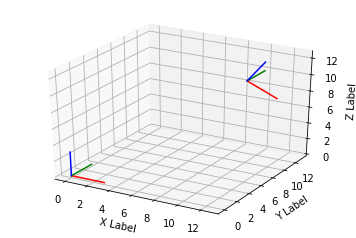

In [93]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(frame[:, 0], frame[:, 1], frame[:, 2]);
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

draw_lines(frame, t_canon, ax);

draw_lines(cam_frame, t_camera, ax);

array([[ 0.15425145,  0.        , -0.98803162],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.98803162,  0.        ,  0.15425145]])

In [94]:
for row in combinations(frame.tolist(), 2):
    print row

([3, 0, 0], [0, 3, 0])
([3, 0, 0], [0, 0, 3])
([0, 3, 0], [0, 0, 3])
